In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directories
os.makedirs('output', exist_ok=True)
os.makedirs('data', exist_ok=True)

def select_least_correlated_funds():
    """
    Download fund data and select the 10 least correlated funds
    """
    # Define fund tickers (excluding bonds)
    all_funds = [
        # Technology funds
        'QQQ', 'XLK', 'VGT', 'FTEC', 'IGM', 'IYW', 'TECL', 'TECS', 'SMH', 'SOXX',
        # Healthcare funds
        'XLV', 'VHT', 'IYH', 'FHLC', 'IHI', 'IBB', 'XBI', 'XPH', 'IHF', 'PJP',
        # Financial funds
        'XLF', 'VFH', 'IYF', 'FNCL', 'KRE', 'KBE', 'IAI', 'KBWB', 'DPST', 'FINU',
        # Energy funds
        'XLE', 'VDE', 'IYE', 'FENY', 'IEO', 'IEZ', 'XOP', 'GUSH', 'DRIP', 'ERX',
        # Real Estate funds
        'XLRE', 'VNQ', 'IYR', 'FREL', 'ICF', 'SCHH', 'RWR', 'REM', 'REZ', 'DRN',
        # Commodities funds
        'GLD', 'IAU', 'SLV', 'USO', 'BNO', 'UNG', 'DBC', 'GSG', 'DJP', 'PDBC',
        # International funds
        'EFA', 'VEA', 'IEFA', 'EEM', 'VWO', 'IEMG', 'FXI', 'EWJ', 'EWG', 'EWU',
        # Cryptocurrency ETFs
        'BITO', 'BITQ', 'BITS', 'DEFI', 'BLKC', 'BLOK', 'DAPP', 'LEGR', 'SATO', 'RIGZ',
        # Mixed Allocation funds
        'AOA', 'AOR', 'AOM', 'AOK', 'USMV', 'SPLV', 'QUAL', 'MTUM', 'VLUE', 'SIZE'
    ]
    
    # Download data for all funds
    print(f"Downloading data for {len(all_funds)} funds...")
    start_date = '2020-03-24'
    end_date = '2025-03-19'
    
    data = yf.download(all_funds, start=start_date, end=end_date, progress=False)
    prices_df = data['Close'].dropna(axis=1, thresh=len(data)*0.8)  # Keep columns with at least 80% data
    prices_df = prices_df.ffill()  # Forward fill missing values
    
    # Calculate returns
    returns_df = prices_df.pct_change().dropna()
    print(f"Successfully downloaded data for {len(returns_df.columns)} funds")
    
    # Calculate correlation matrix
    correlation_matrix = returns_df.corr()
    
    # Selection algorithm: greedy approach to find the least correlated portfolio
    # Start with the fund that has the lowest average correlation to all other funds
    avg_corr_to_all = correlation_matrix.mean()
    first_fund = avg_corr_to_all.idxmin()
    
    selected_funds = [first_fund]
    available_funds = list(set(returns_df.columns) - set(selected_funds))
    
    # Add remaining funds one by one, selecting the one that has the lowest average correlation
    # with the already selected funds
    selection_steps = []
    selection_steps.append({
        "Step": 1,
        "Fund Added": first_fund,
        "Average Correlation": avg_corr_to_all[first_fund]
    })
    
    for i in range(9):  # Select 9 more funds to get a total of 10
        min_avg_corr = float('inf')
        next_fund = None
        
        for fund in available_funds:
            # Calculate average correlation with already selected funds
            correlations = [correlation_matrix.loc[fund, sel] for sel in selected_funds]
            avg_corr = np.mean(correlations)
            
            if avg_corr < min_avg_corr:
                min_avg_corr = avg_corr
                next_fund = fund
        
        selected_funds.append(next_fund)
        available_funds.remove(next_fund)
        
        selection_steps.append({
            "Step": i + 2,
            "Fund Added": next_fund,
            "Average Correlation": min_avg_corr
        })
    
    # Print the selection process
    print("\nFund Selection Process:")
    selection_df = pd.DataFrame(selection_steps)
    print(selection_df)
    
    # Extract mean returns and covariance matrix for selected funds
    selected_returns = returns_df[selected_funds]
    mean_returns = selected_returns.mean() * 252  # Annualize
    cov_matrix = selected_returns.cov() * 252  # Annualize
    
    # Plot the correlation matrix of selected funds
    plt.figure(figsize=(10, 8))
    selected_corr = selected_returns.corr()
    sns.heatmap(selected_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                linewidths=0.5, fmt='.2f')
    plt.title('Correlation Matrix of Selected Portfolio')
    plt.tight_layout()
    plt.savefig('output/selected_correlation_matrix.png')
    plt.close()
    
    # Save data for future use
    mean_returns.to_csv('data/mean_returns.csv')
    cov_matrix.to_csv('data/cov_matrix.csv')
    pd.Series(selected_funds).to_csv('data/selected_funds.csv', index=False, header=False)
    
    # Calculate and display portfolio statistics
    avg_corr = selected_corr.values[np.triu_indices_from(selected_corr, k=1)].mean()
    print(f"\nSelected funds: {', '.join(selected_funds)}")
    print(f"Average correlation between selected funds: {avg_corr:.4f}")
    print(f"Minimum correlation: {selected_corr.values[np.triu_indices_from(selected_corr, k=1)].min():.4f}")
    print(f"Maximum correlation: {selected_corr.values[np.triu_indices_from(selected_corr, k=1)].max():.4f}")
    
    return selected_funds, mean_returns, cov_matrix

if __name__ == "__main__":
    selected_funds, mean_returns, cov_matrix = select_least_correlated_funds()
    print("\nChunk 1 completed. Results saved to 'output' and 'data' directories.")

YF.download() has changed argument auto_adjust default to True
Successfully downloaded data for 81 funds

Fund Selection Process:
   Step Fund Added  Average Correlation
0     1       TECS            -0.528718
1     2       TECL            -0.998995
2     3        REM            -0.002115
3     4       DRIP            -0.157969
4     5        XOP            -0.131799
5     6        UNG             0.009935
6     7        GLD             0.019837
7     8        USO             0.045660
8     9        XBI             0.079088
9    10        FXI             0.110779

Selected funds: TECS, TECL, REM, DRIP, XOP, UNG, GLD, USO, XBI, FXI
Average correlation between selected funds: 0.0025
Minimum correlation: -0.9990
Maximum correlation: 0.5662

Chunk 1 completed. Results saved to 'output' and 'data' directories.


[*********************100%***********************]  1 of 1 completed
C:\Users\zhouy\AppData\Local\Temp\ipykernel_41952\3747673138.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  risk_free_rate = float(risk_free_data['Close'].iloc[-1]) / 100  # Convert from percentage


Using risk-free rate: 4.20%
Calculating efficient frontier with short sales...
Calculating efficient frontier without short sales...

Key Portfolio Metrics:

Global Minimum Variance Portfolio (with short sales):
Expected Return: 0.0071
Expected Volatility: 0.0129
Sharpe Ratio: -2.6988

Maximum Sharpe Ratio Portfolio (with short sales):
Expected Return: 0.4142
Expected Volatility: 0.2704
Sharpe Ratio: 1.3761

Global Minimum Variance Portfolio (without short sales):
Expected Return: 0.0071
Expected Volatility: 0.0129
Sharpe Ratio: -2.6981

Maximum Sharpe Ratio Portfolio (without short sales):
Expected Return: 0.2717
Expected Volatility: 0.2086
Sharpe Ratio: 1.1012

Chunk 2 completed. Efficient frontier plot saved to 'output' directory.


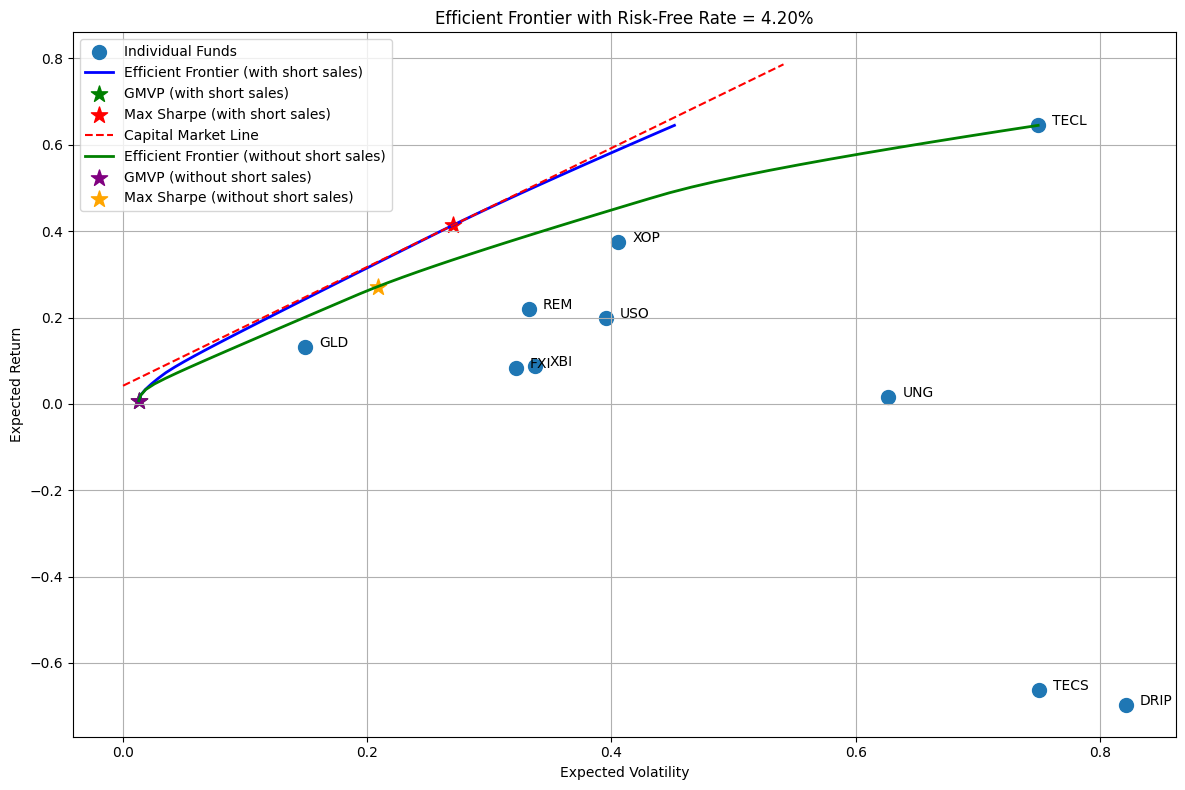

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
import os

# Create directories
os.makedirs('output', exist_ok=True)
os.makedirs('data', exist_ok=True)

def calculate_efficient_frontier():
    """
    Calculate the efficient frontier with and without short sales
    """
    # Load data from Chunk 1
    try:
        selected_funds = pd.read_csv('data/selected_funds.csv', header=None).iloc[:, 0].tolist()
        mean_returns = pd.read_csv('data/mean_returns.csv', index_col=0).iloc[:, 0]
        cov_matrix = pd.read_csv('data/cov_matrix.csv', index_col=0)
    except FileNotFoundError:
        print("Error: Data files not found. Please run Chunk 1 first.")
        return None
    
    # Get risk-free rate (3-month Treasury bill)
    try:
        risk_free_data = yf.download('^IRX', period='1d')
        if not risk_free_data.empty:
            # Make sure we're getting a float, not a Series
            risk_free_rate = float(risk_free_data['Close'].iloc[-1]) / 100  # Convert from percentage
        else:
            risk_free_rate = 0.035  # 3.5% default
    except:
        # Use default if unable to fetch
        risk_free_rate = 0.035  # 3.5%
    
    print(f"Using risk-free rate: {risk_free_rate:.2%}")
    
    # Portfolio performance functions
    def portfolio_performance(weights):
        returns = np.sum(mean_returns * weights)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (returns - risk_free_rate) / volatility
        return returns, volatility, sharpe
    
    def negative_sharpe(weights):
        return -portfolio_performance(weights)[2]
    
    def portfolio_volatility(weights):
        return portfolio_performance(weights)[1]
    
    # Calculate efficient frontier points with short sales
    def calculate_frontier_points(allow_short=True):
        num_assets = len(mean_returns)
        
        # Minimum volatility portfolio
        bounds = tuple((-1, 1) if allow_short else (0, 1) for _ in range(num_assets))
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        
        # Get min volatility portfolio
        result_min_vol = minimize(
            portfolio_volatility, 
            np.array([1/num_assets] * num_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        min_vol_weights = result_min_vol['x']
        min_vol_return, min_vol_volatility, min_vol_sharpe = portfolio_performance(min_vol_weights)
        
        # Get max Sharpe portfolio
        result_max_sharpe = minimize(
            negative_sharpe, 
            np.array([1/num_assets] * num_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        max_sharpe_weights = result_max_sharpe['x']
        max_sharpe_return, max_sharpe_volatility, max_sharpe_sharpe = portfolio_performance(max_sharpe_weights)
        
        # Generate frontier points
        target_returns = np.linspace(min_vol_return, max(mean_returns), 50)
        efficient_list = []
        
        for target in target_returns:
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: portfolio_performance(x)[0] - target}
            ]
            
            result = minimize(
                portfolio_volatility, 
                np.array([1/num_assets] * num_assets),
                method='SLSQP',
                bounds=bounds,
                constraints=constraints
            )
            
            if result['success']:
                ef_weights = result['x']
                ef_return, ef_volatility, ef_sharpe = portfolio_performance(ef_weights)
                efficient_list.append((ef_return, ef_volatility, ef_sharpe, ef_weights))
        
        returns = [r for r, v, s, w in efficient_list]
        volatilities = [v for r, v, s, w in efficient_list]
        
        return {
            'returns': returns,
            'volatilities': volatilities,
            'min_vol': (min_vol_return, min_vol_volatility, min_vol_sharpe, min_vol_weights),
            'max_sharpe': (max_sharpe_return, max_sharpe_volatility, max_sharpe_sharpe, max_sharpe_weights)
        }
    
    # Calculate efficient frontiers
    print("Calculating efficient frontier with short sales...")
    ef_short = calculate_frontier_points(allow_short=True)
    
    print("Calculating efficient frontier without short sales...")
    ef_no_short = calculate_frontier_points(allow_short=False)
    
    # Plot the results
    plt.figure(figsize=(12, 8))
    
    # Plot individual funds
    fund_returns = np.array(mean_returns)
    fund_volatilities = np.array([np.sqrt(cov_matrix.iloc[i, i]) for i in range(len(selected_funds))])
    plt.scatter(fund_volatilities, fund_returns, marker='o', s=100, label='Individual Funds')
    
    # Add fund labels
    for i, fund in enumerate(selected_funds):
        plt.annotate(fund, (fund_volatilities[i], fund_returns[i]), 
                    xytext=(10, 0), textcoords='offset points')
    
    # Plot efficient frontier with short sales
    plt.plot(ef_short['volatilities'], ef_short['returns'], 'b-', linewidth=2, 
            label='Efficient Frontier (with short sales)')
    
    # Plot min vol and max Sharpe portfolios (with short sales)
    plt.scatter(ef_short['min_vol'][1], ef_short['min_vol'][0], s=150, color='g', marker='*', 
               label='GMVP (with short sales)')
    plt.scatter(ef_short['max_sharpe'][1], ef_short['max_sharpe'][0], s=150, color='r', marker='*', 
               label='Max Sharpe (with short sales)')
    
    # Plot Capital Market Line
    cml_x = np.array([0, ef_short['max_sharpe'][1], ef_short['max_sharpe'][1]*2])
    cml_y = np.array([risk_free_rate, ef_short['max_sharpe'][0], 
                      2*ef_short['max_sharpe'][0]-risk_free_rate])
    plt.plot(cml_x, cml_y, 'r--', label='Capital Market Line')
    
    # Plot efficient frontier without short sales
    plt.plot(ef_no_short['volatilities'], ef_no_short['returns'], 'g-', linewidth=2, 
            label='Efficient Frontier (without short sales)')
    
    # Plot min vol and max Sharpe portfolios (without short sales)
    plt.scatter(ef_no_short['min_vol'][1], ef_no_short['min_vol'][0], s=150, color='purple', marker='*', 
               label='GMVP (without short sales)')
    plt.scatter(ef_no_short['max_sharpe'][1], ef_no_short['max_sharpe'][0], s=150, color='orange', marker='*', 
               label='Max Sharpe (without short sales)')
    
    # Finalize the plot
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.title(f'Efficient Frontier with Risk-Free Rate = {risk_free_rate:.2%}')
    plt.legend()
    plt.savefig('output/efficient_frontier.png')
    plt.tight_layout()
    
    # Save key information for Chunk 3
    frontier_data = {
        'with_short': ef_short,
        'without_short': ef_no_short,
        'risk_free_rate': risk_free_rate,
        'selected_funds': selected_funds
    }
    
    # Save risk-free rate for later use
    with open('data/risk_free_rate.txt', 'w') as f:
        f.write(str(risk_free_rate))
    
    # Print key portfolio metrics
    print("\nKey Portfolio Metrics:")
    print("\nGlobal Minimum Variance Portfolio (with short sales):")
    print(f"Expected Return: {ef_short['min_vol'][0]:.4f}")
    print(f"Expected Volatility: {ef_short['min_vol'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_short['min_vol'][2]:.4f}")
    
    print("\nMaximum Sharpe Ratio Portfolio (with short sales):")
    print(f"Expected Return: {ef_short['max_sharpe'][0]:.4f}")
    print(f"Expected Volatility: {ef_short['max_sharpe'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_short['max_sharpe'][2]:.4f}")
    
    print("\nGlobal Minimum Variance Portfolio (without short sales):")
    print(f"Expected Return: {ef_no_short['min_vol'][0]:.4f}")
    print(f"Expected Volatility: {ef_no_short['min_vol'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_no_short['min_vol'][2]:.4f}")
    
    print("\nMaximum Sharpe Ratio Portfolio (without short sales):")
    print(f"Expected Return: {ef_no_short['max_sharpe'][0]:.4f}")
    print(f"Expected Volatility: {ef_no_short['max_sharpe'][1]:.4f}")
    print(f"Sharpe Ratio: {ef_no_short['max_sharpe'][2]:.4f}")
    
    return frontier_data

if __name__ == "__main__":
    frontier_data = calculate_efficient_frontier()
    print("\nChunk 2 completed. Efficient frontier plot saved to 'output' directory.")